# Imports

In [1]:
import imutils
from imutils.video import VideoStream, FileVideoStream
from imutils import face_utils
import cv2
import time
import numpy as np
import dlib
from collections import OrderedDict
from pose_estimator import PoseEstimator
from stabilizer import Stabilizer
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Helper functions

In [2]:
def show_image(path = None, img = None):
    if path:
        img = cv2.imread(path,1)
    while True:
        cv2.imshow('image',img)
        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            # do a bit of cleanup
            cv2.destroyAllWindows()
            break

# Face streamer

In [3]:
# Face streamer class 
class face_streamer:
    def __init__(self, predictor_path, filename = None):
        self.filename = filename
        
        # Initialize dlib's face detector (HOG-based)
        self.detector = dlib.get_frontal_face_detector()
        
        # Create landmark predictor.
        self.predictor = dlib.shape_predictor(predictor_path)
        
#         # Facial landmarks that we use
#         self.facial_landmarks_idxs = OrderedDict([
#             ("nose", (27, 36)),
#             ("face", (0, 26))
#         ])
        
        # Facial landmarks that we use
        self.facial_landmarks_idxs = OrderedDict([
            ("face", (0, 17))
        ])
        
        # Define the pose estimator and stabilizer 
        self.height, self.width = 300, 400
        self.pose_estimator = PoseEstimator(img_size=(self.height, self.width))
        # Define scalar stabilizers for pose.
        self.pose_stabilizers = [Stabilizer(state_num=2, measure_num=1, cov_process=0.1, cov_measure=0.1) 
                            for _ in range(6)]
        
        # RGB and RPY to track
        self.red = []
        self.green = []
        self.blue = []
        self.roll = []
        self.pitch = []
        self.yaw = []
        
        
    def start_stream(self):
        if self.filename:
            self.vs = FileVideoStream(self.filename).start()
        else:
            self.vs = VideoStream(src=0).start()
        print("[INFO] camera sensor warming up...")
        time.sleep(2.0)
            
    def end_stream(self):
        # Do some cleanup
        cv2.destroyAllWindows()
        self.vs.stop()
        del self.vs
        self.num_frames = len(self.red)
        self.frame_vector = range(self.num_frames)
        self.apply_pos()
        self.apply_fft()
        self.apply_rmns()
        self.apply_freq_filtering()

    def stream(self, display_face_bb = False, display_landmarks = False, display_overlay = False, 
               display_aam = False, display_pose_unstable = False, display_pose_stable = False, 
               display_pose_axis = False):
        # Update display parameters
        self.display_face_bb = display_face_bb
        self.display_landmarks = display_landmarks
        self.display_overlay = display_overlay
        self.display_aam = display_aam
        self.display_pose_unstable = display_pose_unstable
        self.display_pose_stable = display_pose_stable
        self.display_pose_axis = display_pose_axis
        self.start_stream()
        
        # Loop and stream
        while True:
            # Process each frame 
            frame = self.process_frame()
                    
            # Show the frame
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            
            # If the `q` key was pressed, break from the loop.
            if key == ord("q"):
                # Do some cleanup 
                self.end_stream()
                break
                
    # Finds faces in the image 
    def find_face(self):
        # Read and resize the frame
        frame = self.vs.read()
        frame = imutils.resize(frame, width=400)
        # Get grayscale image and extract the bounding boxes with the detector 
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = self.detector(gray, 0)
        return frame, gray, rects
    
    # Loops over the faces to update values and to draw on the frame
    def loop_faces(self, frame, gray, rects):
        for rect in rects:
            # Get the bounding box 
            (bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
            # Determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array.
            shape = face_utils.shape_to_np(self.predictor(gray, rect))
            # Get the facial points for the roi
            face_points = self.get_face_points(shape)
            # Comment
#             # Apply the aam
#             aam, num_inside_pixels = self.apply_aam(frame, face_points)
#             # TODO -- take only the ROI, not the whole box 
#             # Get RGB values
#             self.update_rgb(aam, num_inside_pixels) 
            # Uncomment to make it much faster
            aam = 0
            self.update_rgb_fast(frame[bY:bH+bY, bX:bW+bX,:]) 
            # Try pose estimation
            pose = self.pose_estimator.solve_pose_by_68_points(shape.astype('float'))
            # Stabilize the pose
            steady_pose = self.stablize_pose(pose)
            # Update RPY values 
            self.update_rpy(steady_pose)
            # If a face is found, draw on the face
            if shape.any():
                self.shape = shape
                frame = self.draw_frame(frame, shape, face_points, aam, pose, steady_pose, (bX, bY, bW, bH))
                self.frame = frame
        return frame
    
    # Processes the frame by updating numerical values and drawing on it (if specified)
    def process_frame(self):
        frame, gray, rects = self.find_face()
        frame = self.loop_faces(frame, gray, rects)
        return frame
        
                
    def draw_frame(self, frame, shape, face_points, aam, pose, steady_pose, bounds):
        if self.display_aam:
            return aam
        # Extract the bounds
        (bX, bY, bW, bH) = bounds
        # Display bounding box if true
        if self.display_face_bb:
            frame = self.draw_face_bb(frame, (bX, bY, bW, bH))
        # Display facial landmarks if true
        if self.display_landmarks:
            frame = self.draw_landmarks(frame, shape)
        # Display the landmark overlay if true
        if self.display_overlay:
            frame = self.draw_overlay(frame, face_points)
        # Display the pose if true
        if self.display_pose_unstable or self.display_pose_stable:
            frame = self.draw_pose(frame, pose, steady_pose)
        # Display the pose axis if true
        if self.display_pose_axis:
            frame = self.draw_pose_axis(frame, steady_pose)
        return frame
    
    # TODO - this is dummy slow
    # Applies the AAM by turning all cells outside of the face to 0
    def apply_aam(self, frame, face_points):
        # Make the polygon that we will check the bounds with
        face_polygon = Polygon(face_points)
        num_inside_pixels = 0
        aam = frame
        # Loop through and set cells to 0
        for y in range(self.height):
            for x in range(self.width):
                if not face_polygon.contains(Point(x,y)):
                    aam[y,x,:] = 0
                else:
                    num_inside_pixels += 1
        return aam, num_inside_pixels
                            
    # TODO -- only use the mask values, not just the box 
    def update_rgb(self, aam, num_inside_points):
        self.red.append(np.sum(aam[:,:,0])/ num_inside_points / 255)
        self.green.append(np.sum(aam[:,:,1])/ num_inside_points / 255)
        self.blue.append(np.sum(aam[:,:,2])/ num_inside_points / 255)
        
    # TODO -- only use the mask values, not just the box 
    def update_rgb_fast(self, mask):
        self.red.append(np.average(mask[:,:,0]) / 255)
        self.green.append(np.average(mask[:,:,1]) / 255)
        self.blue.append(np.average(mask[:,:,2]) / 255)
    
    # TODO -- roll and pitch may be switched
    def update_rpy(self, steady_pose):
        self.roll.append(steady_pose[0][0])
        self.pitch.append(steady_pose[0][1])
        self.yaw.append(steady_pose[0][2])

    # TODO -- apply POS to combine rgb signal into rPPG signal
    # current just adds the signals 
    def apply_pos(self):
        self.rppg = [r + g + b for r, g, b in zip(self.red,self.green,self.blue)]
    
    # TODO -- figure out if this is the correct way to take the FFT
    def apply_fft(self):
#         self.red_fft = np.abs(fft(self.red))
#         self.green_fft = np.abs(fft(self.green))
#         self.blue_fft = np.abs(fft(self.blue))
        self.rppg_fft = np.abs(fft(self.rppg))
        self.roll_fft = np.abs(fft(self.roll))
        self.pitch_fft = np.abs(fft(self.pitch))
        self.yaw_fft = np.abs(fft(self.yaw))
        
    # TODO -- Fix
    # Applies Rhythmic Motion Noise Suppresion
    def apply_rmns(self):
        self.combined_rpy_fft = self.roll_fft + self.pitch_fft + self.yaw_fft
        self.combined_rpy_fft = self.roll_fft + self.pitch_fft
        self.rppg_fft_rmns = self.rppg_fft - self.combined_rpy_fft
    
    # TODO - Fix freq filtering
    def apply_freq_filtering(self):
        self.rppg_freq_filtered = np.abs(ifft(self.rppg_fft_rmns))
                
    def stablize_pose(self, pose):
        steady_pose = []
        pose_np = np.array(pose).flatten()
        for value, ps_stb in zip(pose_np, self.pose_stabilizers):
            ps_stb.update([value])
            steady_pose.append(ps_stb.state[0])
        steady_pose = np.reshape(steady_pose, (-1, 3))
        return steady_pose 
    
    def get_face_points(self, shape):
        # Loop over the facial landmark regions individually
        for (i, name) in enumerate(self.facial_landmarks_idxs.keys()):
            # Grab the (x, y)-coordinates associated with the
            # face landmark
            (j, k) = self.facial_landmarks_idxs[name]
            face_points = shape[j:k]
            if name == 'face':
                self.face_points = face_points
        return face_points
                
    def draw_face_bb(self, frame, bounds):
        (bX, bY, bW, bH) = bounds
        # Draw the bounding box on the frame
        cv2.rectangle(frame, (bX, bY), (bW+bX, bH+bY), (0, 255, 0), 1)
        return frame
    
    def draw_landmarks(self, frame, shape):
        for (name, (i, j)) in self.facial_landmarks_idxs.items():
            # Loop over the subset of facial landmarks, drawing the specific face part
            for (x, y) in shape[i:j]:
                cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
        return frame
    
    # Displays the overlay of the landmarks 
    def draw_overlay(self, frame, face_points, colors=None, alpha=0.75):
        # Create two copies of the input image -- one for the
        # overlay and one for the final output image
        overlay = frame.copy()
        output = frame.copy()

        # If the colors list is None, initialize it with a unique
        # color for each facial landmark region
        if colors is None:
            colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
                (168, 100, 168), (158, 163, 32),
                (163, 38, 32), (180, 42, 220), (100, 150, 250)]

        # Get the hull
        hull = cv2.convexHull(face_points)
        
        # Draw the contours
        cv2.drawContours(overlay, [hull], -1, colors[0], -1)

        # Apply the transparent overlay
        cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

        # Return the output image
        return output
    
    def draw_pose(self, frame, pose, steady_pose):
        # Display the initial pose annotation if true
        if self.display_pose_unstable:
            self.pose_estimator.draw_annotation_box(frame, pose[0], pose[1], color=(255, 128, 128))
        # Display the stablized pose annotation if true
        if self.display_pose_stable:
            self.pose_estimator.draw_annotation_box(frame, steady_pose[0], steady_pose[1], color=(128, 255, 128))
        return frame 
        
    def draw_pose_axis(self, frame, steady_pose):
        self.pose_estimator.draw_axes(frame, steady_pose[0], steady_pose[1])
        return frame
        
    def plot_rgb(self):
        plt.title('Normalized RGB values as a function of frames')
        plt.plot(self.frame_vector, self.red, color='red', label = 'Red')
        plt.plot(self.frame_vector, self.green, color='green', label='Green')
        plt.plot(self.frame_vector, self.blue, color='blue', label='Blue')
        plt.xlabel('Frame')
        plt.ylabel('Value')
        plt.legend(loc = 'upper right')
        
    def plot_rppg(self):
        plt.title('rPPG signal')
        plt.plot(self.frame_vector, self.rppg)
        plt.xlabel('Frame')
        plt.ylabel('Value')
    
    def plot_rpy(self):
        plt.title('RPY values as a function of frames')
        plt.plot(self.frame_vector, self.roll, color='cyan', label = 'Roll')
        plt.plot(self.frame_vector, self.pitch, color='magenta', label='Pitch')
        plt.plot(self.frame_vector, self.yaw, color='yellow', label='Yaw')
        plt.xlabel('Frame')
        plt.ylabel('Value')
        plt.legend(loc = 'upper right')
        
    def plot_fft(self):
        plt.title('FFT of RPY and rPPG signals')
#         plt.plot(self.frame_vector, self.red_fft, color='red', label = 'Red')
#         plt.plot(self.frame_vector, self.green_fft, color='green', label='Green')
#         plt.plot(self.frame_vector, self.blue_fft, color='blue', label='Blue')
#         plt.plot(self.frame_vector, self.rppg_fft, label = 'rPPG')
#         plt.plot(self.frame_vector, self.roll_fft, color='cyan', label = 'Roll')
#         plt.plot(self.frame_vector, self.pitch_fft, color='magenta', label='Pitch')
#         plt.plot(self.frame_vector, self.yaw_fft, color='yellow', label='Yaw')
        plt.plot(self.frame_vector[:50], self.rppg_fft[:50], label = 'rPPG')
        plt.plot(self.frame_vector[:50], self.roll_fft[:50], color='cyan', label = 'Roll')
        plt.plot(self.frame_vector[:50], self.pitch_fft[:50], color='magenta', label='Pitch')
#         plt.plot(self.frame_vector[:50], self.yaw_fft[:50], color='yellow', label='Yaw')
        plt.legend(loc = 'upper right')
        
    def plot_combined_rpy_fft(self):
        plt.title('Combined FFT of RPY signal')
        plt.plot(self.frame_vector, self.combined_rpy_fft)
        
    def plot_rppg_rmns(self):
        plt.title('FFT of rPPG signal after Rhythmic Noise Suppression')
        plt.plot(self.frame_vector, self.rppg_fft_rmns)
        
    def plot_rppg_freq_filtered(self):
        plt.title('rPPG after Frequency Filter')
        plt.plot(self.frame_vector, self.rppg_freq_filtered)
       

In [4]:
predictor_path = "../models/shape_predictor_68_face_landmarks.dat"
fs = face_streamer(predictor_path)
# If display_aam is true, this is all you will see
fs.stream(display_face_bb = False, display_landmarks = False, display_overlay = True, display_aam = False,
          display_pose_unstable = False, display_pose_stable =  False, display_pose_axis = False)

successful init
[INFO] camera sensor warming up...


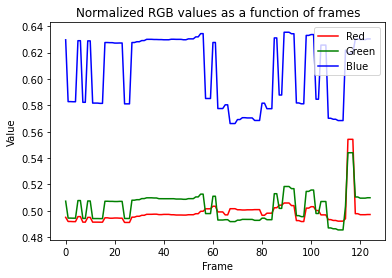

In [5]:
# Graph RGB
fs.plot_rgb()

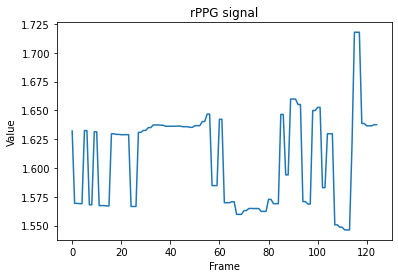

In [6]:
# Graph rPPG signals
fs.plot_rppg()

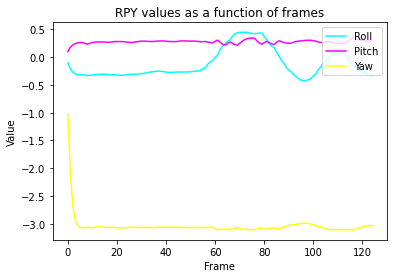

In [7]:
# Graph RPY
fs.plot_rpy()

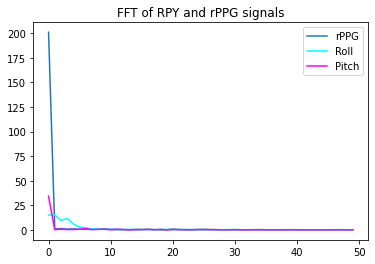

In [8]:
# Graph FFT of RGB and RPY signals signals
fs.plot_fft()

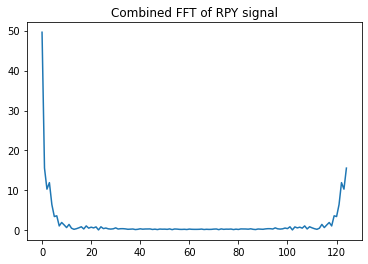

In [9]:
# Graph the combined RPY FFT
fs.plot_combined_rpy_fft()

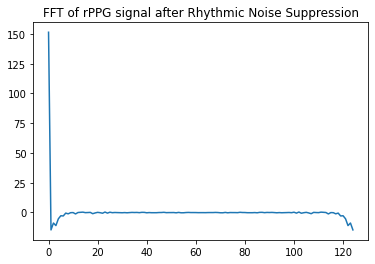

In [10]:
# Graph the rPPG FFT after Rhythmic Noise Suppression
fs.plot_rppg_rmns()

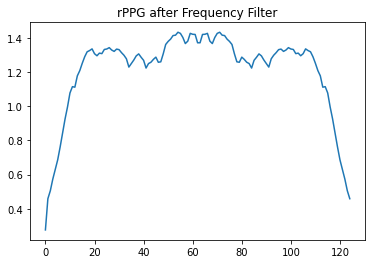

In [11]:
# Graph the rPPG after frequency filtering
fs.plot_rppg_freq_filtered()

In [12]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(227, 184)
polygon = Polygon(fs.face_points)
print(polygon.contains(point))

True


In [13]:
width = fs.width
height = fs.height
face_points = fs.face_points 
frame = fs.frame.copy()

face_polygon = Polygon(face_points)

inside = 0
outside = 0
import time

start = time.time()
for y in range(height):
    for x in range(width):
        if not face_polygon.contains(Point(x,y)):
            outside += 1
            frame[y,x,:] = 0
        else:
            inside += 1
end = time.time()
print(end - start)

1.356619119644165


In [14]:
print(frame.shape)
print(height,width)
print(outside,inside)

(300, 400, 3)
300 400
111577 8423


In [15]:
# Show the frame
while True:
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # If the `q` key was pressed, break from the loop.
    if key == ord("q"):
        # Do some cleanup 
        cv2.destroyAllWindows()
        break

In [16]:
# # # from video 
# fs = face_streamer(predictor_path, filename = '/media/brandon/Seagate HDD/datasets/vicarPPG/Videos/01-mov.mp4')
# fs.stream(display_face_bb = False, display_landmarks = False, display_overlay = True)
# fs.plot_rgb()

In [17]:
# #     Older stream
#     def stream(self, display_face_bb = False, display_landmarks = False, display_overlay = False,
#               display_pose_unstable = False, display_pose_stable = False, display_pose_axis = False):
#         # Update display parameters
#         self.display_face_bb = display_face_bb
#         self.display_landmarks = display_landmarks
#         self.display_overlay = display_overlay
#         self.display_pose_unstable = display_pose_unstable
#         self.display_pose_stable = display_pose_stable
#         self.display_pose_axis = display_pose_axis
#         self.start_stream()
#         # Loop and stream

#         while True:
#             # Analyze the frame
# #             frame, shape, pose, steady_pose, bounds = self.analyze_frame()
# #             # Draw on the frame to display
# #             frame_display = self.draw_frame(frame, shape, pose, steady_pose, bounds)
#             # Read and resize the frame
#             frame = self.vs.read()
#             frame = imutils.resize(frame, width=400)
#             # Get grayscale image and extract the bounding boxes with the detector 
#             gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#             rects = self.detector(gray, 0)
#             # Loop over the face detections 
#             for rect in rects:
#                 # Get the bounding box 
#                 (bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
#                 # TODO -- take only the ROI, not the whole box 
#                 # Get RGB values
#                 self.update_rgb(frame[bY:bH+bY, bX:bW+bX,:]) 
#                 # Determine the facial landmarks for the face region, then
#                 # convert the facial landmark (x, y)-coordinates to a NumPy
#                 # array.
#                 shape = face_utils.shape_to_np(self.predictor(gray, rect))
#                 # Try pose estimation
#                 pose = self.pose_estimator.solve_pose_by_68_points(shape.astype('float'))
#                 # Stabilize the pose
#                 steady_pose = self.stablize_pose(pose)
#                 # Update RPY values 
#                 self.update_rpy(steady_pose)
#                 # Display bounding box if true
#                 if display_face_bb:
#                     frame = self.draw_face_bb(frame, (bX, bY, bW, bH))
#                 # Display facial landmarks if true
#                 if display_landmarks:
#                     frame = self.draw_landmarks(frame, shape)
#                 # Display the landmark overlay if true
#                 if display_overlay:
#                     frame = self.draw_overlay(frame, shape)
#                 # Display the pose if true
#                 if self.display_pose_unstable or self.display_pose_stable:
#                     frame = self.draw_pose(frame, pose, steady_pose)
#                 # Display the pose axis if true
#                 if display_pose_axis:
#                     frame = self.draw_pose_axis(frame, steady_pose)
            
#             # Show the frame
#             cv2.imshow("Frame", frame)
#             key = cv2.waitKey(1) & 0xFF
            
#             # If the `q` key was pressed, break from the loop.
#             if key == ord("q"):
#                 self.frame = frame
#                 print(frame.shape)
#                 self.shape = shape
#                 print(shape.shape)
#                 # Do some cleanup 
#                 self.end_stream()
#                 break


# def display_pose_unstable(self, frame, pose):
#         self.pose_estimator.draw_annotation_box(frame, pose[0], pose[1], color=(255, 128, 128))
#         return frame
        
# def display_pose_stable(self, frame, steady_pose):
#     self.pose_estimator.draw_annotation_box(frame, steady_pose[0], steady_pose[1], color=(128, 255, 128))
#     return frame

# Displays the overlay of the landmarks 
#     def draw_overlay(self, frame, shape, colors=None, alpha=0.75):
#         # Create two copies of the input image -- one for the
#         # overlay and one for the final output image
#         overlay = frame.copy()
#         output = frame.copy()

#         # If the colors list is None, initialize it with a unique
#         # color for each facial landmark region
#         if colors is None:
#             colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
#                 (168, 100, 168), (158, 163, 32),
#                 (163, 38, 32), (180, 42, 220), (100, 150, 250)]

#         # Loop over the facial landmark regions individually
#         for (i, name) in enumerate(self.facial_landmarks_idxs.keys()):
#             # Grab the (x, y)-coordinates associated with the
#             # face landmark
#             (j, k) = self.facial_landmarks_idxs[name]
#             pts = shape[j:k]
#             if name == 'face':
#                 hull = cv2.convexHull(pts)
#                 self.face_points = pts
#                 cv2.drawContours(overlay, [hull], -1, colors[i], -1)

#         # Apply the transparent overlay
#         cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

#         # Return the output image
#         return output

In [18]:
# # Face streamer class 
# class face_streamer:
#     def __init__(self, predictor_path, filename = None):
#         self.filename = filename
        
#         # Initialize dlib's face detector (HOG-based)
#         self.detector = dlib.get_frontal_face_detector()
        
#         # Create landmark predictor.
#         self.predictor = dlib.shape_predictor("../detect-face-parts/shape_predictor_68_face_landmarks.dat")
        
# #         # Facial landmarks that we use
# #         self.facial_landmarks_idxs = OrderedDict([
# #             ("nose", (27, 36)),
# #             ("face", (0, 26))
# #         ])
        
#         # Facial landmarks that we use
#         self.facial_landmarks_idxs = OrderedDict([
#             ("face", (0, 17))
#         ])
        
#         # Define the pose estimator and stabilizer 
#         self.height, self.width = 300, 400
#         self.pose_estimator = PoseEstimator(img_size=(self.height, self.width))
#         # Define scalar stabilizers for pose.
#         self.pose_stabilizers = [Stabilizer(state_num=2, measure_num=1, cov_process=0.1, cov_measure=0.1) 
#                             for _ in range(6)]
        
#         # RGB and RPY to track
#         self.red = []
#         self.green = []
#         self.blue = []
#         self.roll = []
#         self.pitch = []
#         self.yaw = []
        
        
#     def start_stream(self):
#         if self.filename:
#             self.vs = FileVideoStream(self.filename).start()
#         else:
#             self.vs = VideoStream(src=0).start()
#         print("[INFO] camera sensor warming up...")
#         time.sleep(2.0)
            
#     def end_stream(self):
#         # Do some cleanup
#         cv2.destroyAllWindows()
#         self.vs.stop()
#         del self.vs
#         self.num_frames = len(self.red)
#         self.frame_vector = range(self.num_frames)
#         self.apply_pos()
#         self.apply_fft()
#         self.apply_rmns()
#         self.apply_freq_filtering()

#     def stream(self, display_face_bb = False, display_landmarks = False, display_overlay = False,
#               display_pose_unstable = False, display_pose_stable = False, display_pose_axis = False):
#         # Update display parameters
#         self.display_face_bb = display_face_bb
#         self.display_landmarks = display_landmarks
#         self.display_overlay = display_overlay
#         self.display_pose_unstable = display_pose_unstable
#         self.display_pose_stable = display_pose_stable
#         self.display_pose_axis = display_pose_axis
#         self.start_stream()
        
#         # Loop and stream
#         while True:
#             # Process each frame 
#             frame = self.process_frame()
                    
#             # Show the frame
#             cv2.imshow("Frame", frame)
#             key = cv2.waitKey(1) & 0xFF
            
#             # If the `q` key was pressed, break from the loop.
#             if key == ord("q"):
#                 # Do some cleanup 
#                 self.end_stream()
#                 break
                
#     # Finds faces in the image 
#     def find_face(self):
#         # Read and resize the frame
#         frame = self.vs.read()
#         frame = imutils.resize(frame, width=400)
#         # Get grayscale image and extract the bounding boxes with the detector 
#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         rects = self.detector(gray, 0)
#         return frame, gray, rects
    
#     # Loops over the faces to update values and to draw on the frame
#     def loop_faces(self, frame, gray, rects):
#         for rect in rects:
#             # Get the bounding box 
#             (bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
#             # Determine the facial landmarks for the face region, then
#             # convert the facial landmark (x, y)-coordinates to a NumPy
#             # array.
#             shape = face_utils.shape_to_np(self.predictor(gray, rect))
#             # Get the facial points for the roi
#             face_points = self.get_face_points(shape)
#             # Apply the aam
#             aam, num_inside_pixels = self.apply_aam(frame,)
#             # TODO -- take only the ROI, not the whole box 
#             # Get RGB values
#             self.update_rgb(frame[bY:bH+bY, bX:bW+bX,:]) 
#             # Try pose estimation
#             pose = self.pose_estimator.solve_pose_by_68_points(shape.astype('float'))
#             # Stabilize the pose
#             steady_pose = self.stablize_pose(pose)
#             # Update RPY values 
#             self.update_rpy(steady_pose)
#             # If a face is found, draw on the face
#             if shape.any():
#                 self.shape = shape
#                 frame = self.draw_frame(frame, shape, face_points, pose, steady_pose, (bX, bY, bW, bH))
#                 self.frame = frame
#         return frame
    
#     # Processes the frame by updating numerical values and drawing on it (if specified)
#     def process_frame(self):
#         frame, gray, rects = self.find_face()
#         frame = self.loop_faces(frame, gray, rects)
#         return frame
        
                
#     def draw_frame(self, frame, shape, face_points, pose, steady_pose, bounds):
#         # Extract the bounds
#         (bX, bY, bW, bH) = bounds
#         # Display bounding box if true
#         if self.display_face_bb:
#             frame = self.display_face_bb(frame, (bX, bY, bW, bH))
#         # Display facial landmarks if true
#         if self.display_landmarks:
#             frame = self.draw_landmarks(frame, shape)
#         # Display the landmark overlay if true
#         if self.display_overlay:
#             frame = self.draw_overlay(frame, face_points)
#         # Display the pose if true
#         if self.display_pose_unstable or self.display_pose_stable:
#             frame = self.draw_pose(frame, pose, steady_pose)
#         # Display the pose axis if true
#         if self.display_pose_axis:
#             frame = self.draw_pose_axis(frame, steady_pose)
#         return frame
    
#     # Applies the AAM by turning all cells outside of the face to 0
#     def apply_aam(self, frame, face_points):
#         # Make the polygon that we will check the bounds with
#         face_polygon = Polygon(face_points)
#         num_inside_pixels = 0
#         aam = frame.copy()
#         # Loop through and set cells to 0
#         for y in range(self.height):
#             for x in range(self.width):
#                 if not face_polygon.contains(Point(x,y)):
#                     aam[y,x,:] = 0
#                 else:
#                     num_inside_pixels += 1
#         return aam, num_inside_pixels
                            
#     # TODO -- only use the mask values, not just the box 
#     def update_rgb(self, mask):
#         self.red.append(np.average(mask[:,:,0]) / 255)
#         self.green.append(np.average(mask[:,:,1]) / 255)
#         self.blue.append(np.average(mask[:,:,2]) / 255)
    
#     # TODO -- roll and pitch may be switched
#     def update_rpy(self, steady_pose):
#         self.roll.append(steady_pose[0][0])
#         self.pitch.append(steady_pose[0][1])
#         self.yaw.append(steady_pose[0][2])

#     # TODO -- apply POS to combine rgb signal into rPPG signal
#     # current just adds the signals 
#     def apply_pos(self):
#         self.rppg = [r + g + b for r, g, b in zip(self.red,self.green,self.blue)]
    
#     # TODO -- figure out if this is the correct way to take the FFT
#     def apply_fft(self):
# #         self.red_fft = np.abs(fft(self.red))
# #         self.green_fft = np.abs(fft(self.green))
# #         self.blue_fft = np.abs(fft(self.blue))
#         self.rppg_fft = np.abs(fft(self.rppg))
#         self.roll_fft = np.abs(fft(self.roll))
#         self.pitch_fft = np.abs(fft(self.pitch))
#         self.yaw_fft = np.abs(fft(self.yaw))
        
#     # TODO -- Fix
#     # Applies Rhythmic Motion Noise Suppresion
#     def apply_rmns(self):
#         self.combined_rpy_fft = self.roll_fft + self.pitch_fft + self.yaw_fft
#         self.combined_rpy_fft = self.roll_fft + self.pitch_fft
#         self.rppg_fft_rmns = self.rppg_fft - self.combined_rpy_fft
    
#     # TODO - Fix freq filtering
#     def apply_freq_filtering(self):
#         self.rppg_freq_filtered = np.abs(ifft(self.rppg_fft_rmns))
                
#     def stablize_pose(self, pose):
#         steady_pose = []
#         pose_np = np.array(pose).flatten()
#         for value, ps_stb in zip(pose_np, self.pose_stabilizers):
#             ps_stb.update([value])
#             steady_pose.append(ps_stb.state[0])
#         steady_pose = np.reshape(steady_pose, (-1, 3))
#         return steady_pose 
    
#     def get_face_points(self, shape):
#         # Loop over the facial landmark regions individually
#         for (i, name) in enumerate(self.facial_landmarks_idxs.keys()):
#             # Grab the (x, y)-coordinates associated with the
#             # face landmark
#             (j, k) = self.facial_landmarks_idxs[name]
#             face_points = shape[j:k]
#             if name == 'face':
#                 self.face_points = face_points
#         return face_points
                
#     def draw_face_bb(self, frame, bounds):
#         (bX, bY, bW, bH) = bounds
#         # Draw the bounding box on the frame
#         cv2.rectangle(frame, (bX, bY), (bW+bX, bH+bY), (0, 255, 0), 1)
#         return frame
    
#     def draw_landmarks(self, frame, shape):
#         for (name, (i, j)) in self.facial_landmarks_idxs.items():
#             # Loop over the subset of facial landmarks, drawing the specific face part
#             for (x, y) in shape[i:j]:
#                 cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
#         return frame
    
#     # Displays the overlay of the landmarks 
#     def draw_overlay(self, frame, face_points, colors=None, alpha=0.75):
#         # Create two copies of the input image -- one for the
#         # overlay and one for the final output image
#         overlay = frame.copy()
#         output = frame.copy()

#         # If the colors list is None, initialize it with a unique
#         # color for each facial landmark region
#         if colors is None:
#             colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
#                 (168, 100, 168), (158, 163, 32),
#                 (163, 38, 32), (180, 42, 220), (100, 150, 250)]

#         # Get the hull
#         hull = cv2.convexHull(face_points)
        
#         # Draw the contours
#         cv2.drawContours(overlay, [hull], -1, colors[0], -1)

#         # Apply the transparent overlay
#         cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

#         # Return the output image
#         return output
    
#     def draw_pose(self, frame, pose, steady_pose):
#         # Display the initial pose annotation if true
#         if self.display_pose_unstable:
#             self.pose_estimator.draw_annotation_box(frame, pose[0], pose[1], color=(255, 128, 128))
#         # Display the stablized pose annotation if true
#         if self.display_pose_stable:
#             self.pose_estimator.draw_annotation_box(frame, steady_pose[0], steady_pose[1], color=(128, 255, 128))
#         return frame 
        
#     def draw_pose_axis(self, frame, steady_pose):
#         self.pose_estimator.draw_axes(frame, steady_pose[0], steady_pose[1])
#         return frame
        
#     def plot_rgb(self):
#         plt.title('Normalized RGB values as a function of frames')
#         plt.plot(self.frame_vector, self.red, color='red', label = 'Red')
#         plt.plot(self.frame_vector, self.green, color='green', label='Green')
#         plt.plot(self.frame_vector, self.blue, color='blue', label='Blue')
#         plt.xlabel('Frame')
#         plt.ylabel('Value')
#         plt.legend(loc = 'upper right')
        
#     def plot_rppg(self):
#         plt.title('rPPG signal')
#         plt.plot(self.frame_vector, self.rppg)
#         plt.xlabel('Frame')
#         plt.ylabel('Value')
    
#     def plot_rpy(self):
#         plt.title('RPY values as a function of frames')
#         plt.plot(self.frame_vector, self.roll, color='cyan', label = 'Roll')
#         plt.plot(self.frame_vector, self.pitch, color='magenta', label='Pitch')
#         plt.plot(self.frame_vector, self.yaw, color='yellow', label='Yaw')
#         plt.xlabel('Frame')
#         plt.ylabel('Value')
#         plt.legend(loc = 'upper right')
        
#     def plot_fft(self):
#         plt.title('FFT of RPY and rPPG signals')
# #         plt.plot(self.frame_vector, self.red_fft, color='red', label = 'Red')
# #         plt.plot(self.frame_vector, self.green_fft, color='green', label='Green')
# #         plt.plot(self.frame_vector, self.blue_fft, color='blue', label='Blue')
# #         plt.plot(self.frame_vector, self.rppg_fft, label = 'rPPG')
# #         plt.plot(self.frame_vector, self.roll_fft, color='cyan', label = 'Roll')
# #         plt.plot(self.frame_vector, self.pitch_fft, color='magenta', label='Pitch')
# #         plt.plot(self.frame_vector, self.yaw_fft, color='yellow', label='Yaw')
#         plt.plot(self.frame_vector[:50], self.rppg_fft[:50], label = 'rPPG')
#         plt.plot(self.frame_vector[:50], self.roll_fft[:50], color='cyan', label = 'Roll')
#         plt.plot(self.frame_vector[:50], self.pitch_fft[:50], color='magenta', label='Pitch')
# #         plt.plot(self.frame_vector[:50], self.yaw_fft[:50], color='yellow', label='Yaw')
#         plt.legend(loc = 'upper right')
        
#     def plot_combined_rpy_fft(self):
#         plt.title('Combined FFT of RPY signal')
#         plt.plot(self.frame_vector, self.combined_rpy_fft)
        
#     def plot_rppg_rmns(self):
#         plt.title('FFT of rPPG signal after Rhythmic Noise Suppression')
#         plt.plot(self.frame_vector, self.rppg_fft_rmns)
        
#     def plot_rppg_freq_filtered(self):
#         plt.title('rPPG after Frequency Filter')
#         plt.plot(self.frame_vector, self.rppg_freq_filtered)
                